Testing Python implementations of GAMLSS models

- PyGAM: not maintained over time; not compatible with Scipy
- PyNM: requires R installation
- statsmodels GAM: splines not generating predictions correctly

In [ ]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_excel('./tests/input_data/HSC_Normals_Biomarkers_FINAL.xlsx')
display(df.head())

# assert in script
print(df[['Damage_Micro', 'Age_yrs_']].dtypes)

,NAMES,FileName,Age_yrs_,Age_mo_,Sex,Vendor,FieldStrength,Tissue,Integrity_LBP,Damage_Macro,Damage_Micro,Intensity,Volume_ICV_Ratio
0,Normal_2_N_108,Normal_2_N_108.mat,10.666667,128,M,Philips Medical Systems,1.5,WM,133.159912,1009.391235,8.936866,266.466400,0.354616
1,Normal_2_N_115,Normal_2_N_115.mat,4.333333,52,M,Philips Medical Systems,1.5,WM,137.348831,986.279907,9.160627,252.958496,0.301450
2,Normal_2_N_119,Normal_2_N_119.mat,3.000000,36,M,Philips Medical Systems,3.0,WM,128.482758,1496.449097,6.460612,239.636078,0.294173
3,Normal_2_N_120,Normal_2_N_120.mat,17.000000,204,F,Philips Medical Systems,3.0,WM,129.750000,1646.981567,8.725435,245.952682,0.372460
4,Normal_2_N_121,Normal_2_N_121.mat,4.000000,48,M,Philips Medical Systems,3.0,WM,130.199997,1315.294189,10.807362,237.334259,0.292972


Damage_Micro    float64
Age_yrs_        float64
dtype: object


# Quantile regression

      q          a        b1        b2       lb1       ub1       lb2       ub2
0  0.03   4.102822  0.627400 -0.026490  0.124611  1.130189 -0.049600 -0.003380
1  0.97  11.639621 -0.011491  0.004769 -0.368496  0.345514 -0.011076  0.020615
{'a': np.float64(7.121118750306916), 'b1': np.float64(0.4674039353231718), 'b2': np.float64(-0.017647343451878628), 'lb1': np.float64(0.2728724000805394), 'ub1': np.float64(0.6619354705658043), 'lb2': np.float64(-0.02672509615655293), 'ub2': np.float64(-0.008569590747204325)}
0    0.03
1    0.97
Name: q, dtype: float64


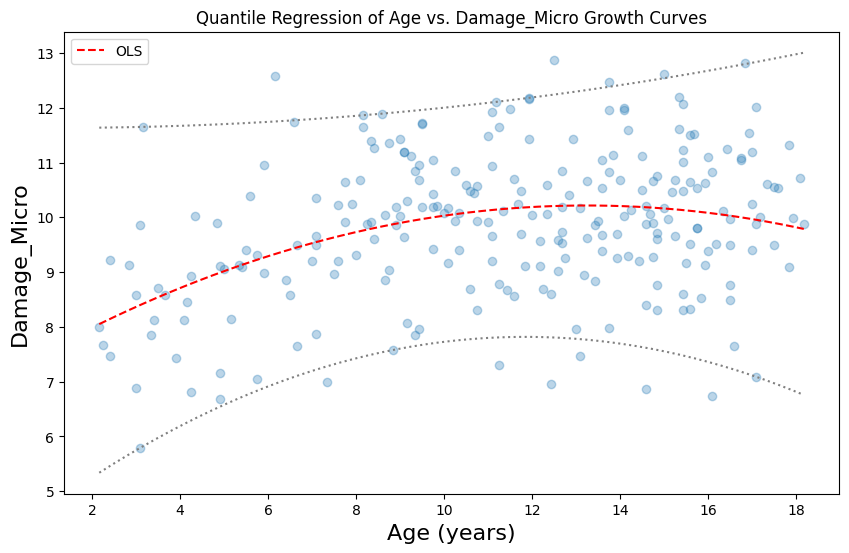

In [ ]:
import statsmodels.formula.api as smf

FEATURE = 'Damage_Micro' # option for listing biomarkers to plot
TISSUE = 'GM' # default WM and GM, option for listing tissue types
SEX = 'F' # default F and M
AGE_COL = 'Age_yrs_' # input for age column
quantiles = [0.03, 0.97]

# Filter and transform the data
final_df = df[df['Tissue'] == TISSUE]
final_df = final_df[final_df['Sex'] == SEX]
final_df = final_df.dropna(subset=[FEATURE, AGE_COL]).reset_index(drop=True)

# Add quadratic term for Age_yrs_
final_df['Age_yrs_2'] = final_df[AGE_COL] ** 2

# Update quantile regression model to include quadratic term
mod = smf.quantreg(f"{FEATURE} ~ {AGE_COL} + Age_yrs_2", final_df)

def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params["Intercept"], res.params[AGE_COL], res.params["Age_yrs_2"]] + res.conf_int().iloc[1:].values.flatten().tolist()

models = [fit_model(x) for x in quantiles]
models = pd.DataFrame(models, columns=["q", "a", "b1", "b2", "lb1", "ub1", "lb2", "ub2"])

ols = smf.ols(f"{FEATURE} ~ {AGE_COL} + Age_yrs_2", final_df).fit()
ols_ci = ols.conf_int().iloc[1:].values.flatten()
ols = dict(
    a=ols.params["Intercept"],
    b1=ols.params[AGE_COL],
    b2=ols.params["Age_yrs_2"],
    lb1=ols_ci[0],
    ub1=ols_ci[1],
    lb2=ols_ci[2],
    ub2=ols_ci[3],
)

print(models)
print(ols)
print(models.q)

# Generate x values for plotting
x = np.linspace(final_df[AGE_COL].min(), final_df[AGE_COL].max(), 200)

# Function to compute y values with quadratic term
get_y = lambda a, b1, b2: a + b1 * x + b2 * x ** 2

# Plot quantile regression lines
fig, ax = plt.subplots(figsize=(10, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b1[i], models.b2[i])
    ax.plot(x, y, linestyle="dotted", color="grey")

# Scatter plot of data
ax.scatter(final_df[AGE_COL], final_df[FEATURE], alpha=0.3)
ax.set_xlabel("Age", fontsize=16)
ax.set_ylabel(f"{FEATURE}", fontsize=16)

#### option to plot if disease data is input

# Plot OLS regression line
ols_line = get_y(ols["a"], ols["b1"], ols["b2"])
ax.plot(x, ols_line, color="red", linestyle="--", label="OLS")

# Add legend and title
plt.title(f"Quantile Regression of Age vs. {FEATURE} Growth Curves")
plt.xlabel("Age (years)")
plt.ylabel(f"{FEATURE}")
plt.legend()
plt.show()

In [1]:
import pickle

In [4]:
with open('/Users/karissachan/Documents/GitHub/karissachan/tiny-curvy-brains/tests/test_output/results.pkl', 'rb') as f:
    data = pickle.load(f)
print(data)

{'GM': {'M': {'Intensity': {'model_parameters': {'mu': array(['Not Applicable'], dtype='<U14'), 'sigma': array(['Not Applicable'], dtype='<U14'), 'nu': array(['Not Applicable'], dtype='<U14'), 'tau': array(['Not Applicable'], dtype='<U14'), 'coefs': {np.str_('(Intercept)'): array([276.34782774]), np.str_('pb(Age_yrs_)'): array([0.17526935])}}, 'centiles':    cent        per
1   3.0   2.702703
2  15.0  16.666667
3  50.0  50.000000
4  85.0  85.585586
5  97.0  97.747748}}, 'F': {'Intensity': {'model_parameters': {'mu': array(['Not Applicable'], dtype='<U14'), 'sigma': array(['Not Applicable'], dtype='<U14'), 'nu': array(['Not Applicable'], dtype='<U14'), 'tau': array(['Not Applicable'], dtype='<U14'), 'coefs': {np.str_('(Intercept)'): array([275.17124358]), np.str_('pb(Age_yrs_)'): array([0.31642025])}}, 'centiles':    cent        per
1   3.0   2.857143
2  15.0  11.836735
3  50.0  48.979592
4  85.0  87.755102
5  97.0  96.734694}}}, 'WM': {'M': {'Intensity': {'model_parameters': {'mu': arr